In [19]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [2]:
# Download caption annotation files
#annotation_folder = '/annotations/'
#if not os.path.exists(os.path.abspath('.') + annotation_folder):
 # annotation_zip = tf.keras.utils.get_file('captions.zip',
  #                                        cache_subdir=os.path.abspath('.'),
   #                                       origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
    #                                      extract = True)
  #annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  #os.remove(annotation_zip)

In [3]:
#with open(annotation_file, 'r') as f:
 #   annotations = json.load(f)

In [4]:
#annotations['']

In [5]:
#image_path_to_caption = collections.defaultdict(list)
#for val in annotations['annotations']:
#   caption = f"<start> {val['caption']} <end>"
#   image_path = images + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
#   image_path_to_caption[image_path].append(caption)

In [6]:
# image_path_to_caption

In [20]:
#Import the dataset and read the image into a seperate variable

images='Flickr8K/Images'

all_imgs = glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [21]:
#Visualise both the images & text present in the dataset
text = open('Flickr8K/captions.txt', 'r', encoding = 'utf-8').read()
text = text.split('\n')
text.pop(0)

'image,caption'

In [22]:
#Import the dataset and read the text file into a seperate variable
text_file = 'Flickr8K/captions.txt'
def load_doc(filename):
    text = open(filename, 'r', encoding = 'utf-8').read()
    return text

doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


In [23]:
def MapImageCaptions(doc):
    captionDict = collections.defaultdict(list)
    text_lines = doc.split('\n')
    # remove the heading line and empty lines
    text_lines = [t for t in text_lines[1:] if len(t)>0]
    for line in text_lines:
        dict_index, dict_val = line.split('jpg,', 1) # splitting only on comma can be disastrous if comma are present in caption
        dict_index = images + '/' + dict_index + 'jpg'
        if dict_index not in captionDict:
            captionDict[dict_index] = list()
        captionDict[dict_index].append(f"<start> {dict_val} <end>")
    return captionDict

In [24]:
image_path_to_caption = MapImageCaptions(doc)

In [25]:
image_path_to_caption

defaultdict(list,
            {'Flickr8K/Images/1000268201_693b08cb0e.jpg': ['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
              '<start> A girl going into a wooden building . <end>',
              '<start> A little girl climbing into a wooden playhouse . <end>',
              '<start> A little girl climbing the stairs to her playhouse . <end>',
              '<start> A little girl in a pink dress going into a wooden cabin . <end>'],
             'Flickr8K/Images/1001773457_577c3a7d70.jpg': ['<start> A black dog and a spotted dog are fighting <end>',
              '<start> A black dog and a tri-colored dog playing with each other on the road . <end>',
              '<start> A black dog and a white dog with brown spots are staring at each other in the street . <end>',
              '<start> Two dogs of different breeds looking at each other on the road . <end>',
              '<start> Two dogs on pavement moving toward each other . <en

In [26]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will 
# lead to 30,000 examples.
train_image_paths = image_paths
print(len(train_image_paths))

8091


In [27]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> A boy in a park playing with two orange balls . <end>


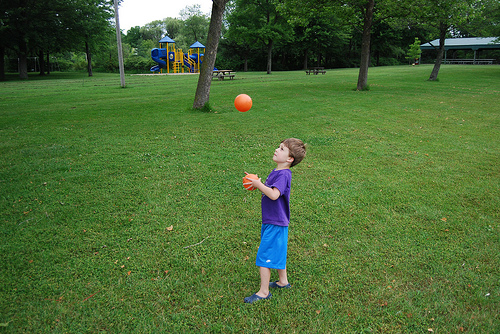

In [28]:
print(train_captions[0])
Image.open(img_name_vector[0])

### Preprocess the images using InceptionV3

In [29]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [30]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [43]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

### Preprocess and tokenize the captions

In [31]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [32]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [33]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [34]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [35]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [36]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

### Split the data into training and testing

In [37]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [38]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32360, 32360, 8095, 8095)

### Create a tf.data dataset for training

In [39]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [40]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [44]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [45]:
sample_img_batch, sample_cap_batch = next(iter(dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape)

(64, 64, 2048)
(64, 39)


<tf.Tensor: shape=(64, 64, 2048), dtype=float32, numpy=
array([[[0.02347206, 0.        , 1.5597339 , ..., 0.15567082,
         0.        , 0.24170703],
        [0.        , 0.        , 2.216888  , ..., 1.3627156 ,
         0.        , 0.        ],
        [0.188297  , 0.        , 3.82798   , ..., 1.9306271 ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.80246806, ..., 1.2653278 ,
         0.        , 0.        ],
        [0.        , 0.        , 1.2859256 , ..., 0.8272709 ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.68992025,
         0.        , 0.        ]],

       [[0.        , 0.        , 1.6221933 , ..., 0.        ,
         2.285224  , 0.        ],
        [0.        , 0.        , 0.2746028 , ..., 0.29738376,
         1.9476167 , 0.        ],
        [0.        , 0.        , 0.10574332, ..., 0.43754727,
         2.4001508 , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.

In [47]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [48]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0
    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        # print('test_batch', batch)
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss = total_loss/test_num_steps
    return avg_test_loss

@tf.function
def test_step(img_tensor, target):
    loss = 0
    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * batch_size, 1)
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
    # passing the features through the decoder
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        # predictions : (64,8329)
        loss += loss_function(target[:, i], predictions)
      
        predicted_id = tf.argmax(predictions[0])
        # dec_input = tf.expand_dims([predicted_id]*batch_size, 1)
 
    avg_loss = (loss / int(target.shape[1]))
        
    return loss, avg_loss

In [49]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

EPOCHS = 20
test_loss_plot = []
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.6887
Epoch 1 Batch 100 Loss 1.4619
Epoch 1 Batch 200 Loss 1.2151
Epoch 1 Batch 300 Loss 1.1404
Epoch 1 Batch 400 Loss 1.0148
Epoch 1 Batch 500 Loss 1.2206
Epoch 1 Loss 1.269718
Time taken for 1 epoch 214.12530779838562 sec

Epoch 2 Batch 0 Loss 1.0340
Epoch 2 Batch 100 Loss 1.0572
Epoch 2 Batch 200 Loss 0.9121
Epoch 2 Batch 300 Loss 0.9583
Epoch 2 Batch 400 Loss 0.9743
Epoch 2 Batch 500 Loss 0.8900
Epoch 2 Loss 0.986350
Time taken for 1 epoch 148.65143704414368 sec

Epoch 3 Batch 0 Loss 0.9256
Epoch 3 Batch 100 Loss 0.8623
Epoch 3 Batch 200 Loss 0.9680
Epoch 3 Batch 300 Loss 0.8890
Epoch 3 Batch 400 Loss 0.8396
Epoch 3 Batch 500 Loss 0.8337
Epoch 3 Loss 0.894277
Time taken for 1 epoch 147.98689770698547 sec

Epoch 4 Batch 0 Loss 0.9532
Epoch 4 Batch 100 Loss 0.8076
Epoch 4 Batch 200 Loss 0.9066
Epoch 4 Batch 300 Loss 0.8507
Epoch 4 Batch 400 Loss 0.8174
Epoch 4 Batch 500 Loss 0.8072
Epoch 4 Loss 0.831179
Time taken for 1 epoch 148.07115578651428 sec

Epoch 5 Batc

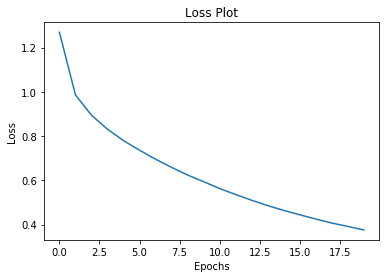

In [50]:
plt.plot(loss_plot)
plt.plot(test_loss_plot, color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [51]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [52]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a little girl is trying to look into a dark window <end>
Prediction Caption: a girl in a pink jacket is up and is standing in a clear glass of the orange object outside <end>


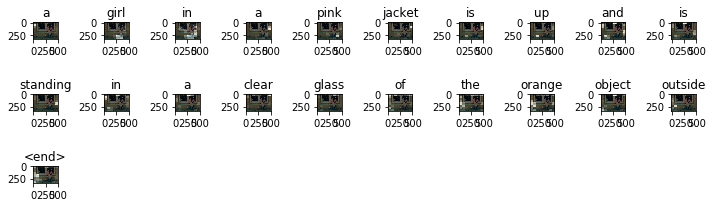

In [53]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

### Try it on your own images

65536/64400 [==============================] - 0s 4us/step
Prediction Caption: a young boy surfing in the water <end>


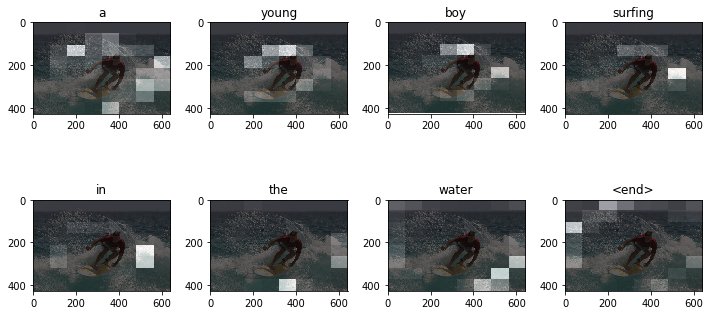

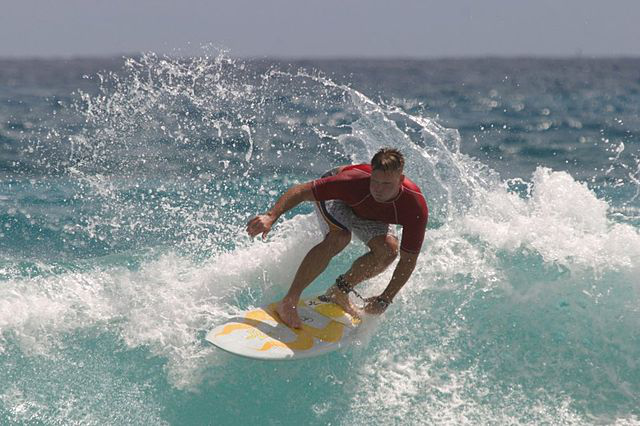

In [54]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)